In [1]:
import pymongo
client = pymongo.MongoClient()
table = client.clash.game_all

In [2]:
def get_team_bans(game_data):
    team_bans = {100:[],200:[]}
    for t in game_data["teams"]:
        for b in t["bans"]:
            team_bans[t["teamId"]].append(b["championId"])
    return team_bans

def get_team_picks(game_data):
    team_picks = {100:[],200:[]}
    for p in game_data["participants"]:
        team_picks[p["teamId"]].append(p["championId"])
    return team_picks

In [3]:
from static_data import ddragon
dd = ddragon.ddragon()

pick_ban_data = []

for g in table.find({"platformId":"EUW1","queueId":700},{"gameId":1,"teams":1,"participants":1}):
    team_bans = get_team_bans(g)
    team_picks = get_team_picks(g)
    
    for teamId in [100,200]:
        win = g["teams"][0 if teamId == 100 else 1]["win"] == "Win"
        
        type_ = "ban"
        for ban in team_bans[teamId]:
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":ban,
                "champion":dd.getChampion(ban).name if ban > 0 else "no ban"
            }
            pick_ban_data.append(row)
        
        type_ = "pick"
        for n_role , pick in enumerate(team_picks[teamId]):
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":pick,
                "champion":dd.getChampion(pick).name
            }
            pick_ban_data.append(row)

In [4]:
nb_games = table.find({"platformId":"EUW1","queueId":700},{"gameId":1,"teams":1,"participants":1}).count()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


In [5]:
import pandas as pd
df = pd.DataFrame(pick_ban_data)
df

,gameId,teamId,win,type,championId,champion
0,4219134238,100,True,ban,412,Thresh
1,4219134238,100,True,ban,8,Vladimir
2,4219134238,100,True,ban,145,Kai'Sa
3,4219134238,100,True,ban,38,Kassadin
4,4219134238,100,True,ban,98,Shen
...,...,...,...,...,...,...
1714655,4219320489,200,True,pick,18,Tristana
1714656,4219320489,200,True,pick,20,Nunu & Willump
1714657,4219320489,200,True,pick,45,Veigar
1714658,4219320489,200,True,pick,122,Darius


In [6]:
banrate = (
    # Selecting bans
    df[df["type"] == "ban"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most banned champions
        .sort_values("championId", ascending=False)
        ["championId"]
        # Divided by number of games to get a percentage
        /nb_games
)

banrate.head(10)

champion
Yasuo      0.410169
Morgana    0.290262
Zed        0.249647
Kai'Sa     0.244562
Pyke       0.221945
Vayne      0.213302
Jax        0.206012
Darius     0.201824
Thresh     0.198570
Caitlyn    0.197998
Name: championId, dtype: float64

In [7]:
pickrate = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
        # Divided by number of games to get a percentage
        /nb_games
)

pickrate.head(10)

champion
Xayah        0.274818
Morgana      0.262046
Kai'Sa       0.248352
Caitlyn      0.248003
Nautilus     0.218154
Rakan        0.196354
Thresh       0.182532
Malphite     0.173562
Leona        0.163753
Jarvan IV    0.163123
Name: championId, dtype: float64

In [8]:
wins = (
    # Selecting picks
    df[((df["type"] == "pick") & (df["win"]))]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

picks = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

winrate = (wins/picks).fillna(0).sort_values(ascending=False)
winrate.head(10)

champion
Blitzcrank        0.548505
Zilean            0.546213
Nunu & Willump    0.542221
Swain             0.541436
Zac               0.539064
Taric             0.536574
Ashe              0.533704
Volibear          0.533459
Mordekaiser       0.532120
Graves            0.531634
Name: championId, dtype: float64

In [9]:
presence = pickrate.add(banrate, fill_value=0).sort_values(ascending=False)
presence

champion
Morgana         0.552308
Yasuo           0.520196
Kai'Sa          0.492914
Xayah           0.456090
Caitlyn         0.446001
                  ...   
Singed          0.017485
Nidalee         0.016003
Aurelion Sol    0.015758
Kog'Maw         0.015385
Kalista         0.011536
Name: championId, Length: 146, dtype: float64

In [10]:
ban_winrate = {}
gby = df.groupby("champion")
for i in df["champion"].unique():
    val_count = gby.get_group(i)["win"].value_counts()
    ban_winrate[i] = val_count[True] / (val_count[True] + val_count[False])

In [11]:
df_clash = pd.DataFrame([banrate,pickrate,winrate, presence, pd.Series(ban_winrate)]).T.fillna(0)
df_clash.columns = ["banrate", "pickrate", "winrate", "presence", "ban_winrate"]

df_clash

,banrate,pickrate,winrate,presence,ban_winrate
Yasuo,0.410169,0.110028,0.506944,0.520196,0.486322
Morgana,0.290262,0.262046,0.510505,0.552308,0.523093
Zed,0.249647,0.054495,0.497217,0.304142,0.488207
Kai'Sa,0.244562,0.248352,0.478208,0.492914,0.485411
Pyke,0.221945,0.108593,0.503115,0.330538,0.492519
...,...,...,...,...,...
Trundle,0.007780,0.026583,0.484423,0.034362,0.489817
Nidalee,0.007313,0.008690,0.500671,0.016003,0.494169
Maokai,0.006147,0.034654,0.478963,0.040801,0.479989
Kog'Maw,0.005097,0.010288,0.461451,0.015385,0.494314


In [12]:
df_clash.loc["Yasuo"]

banrate        0.410169
pickrate       0.110028
winrate        0.506944
presence       0.520196
ban_winrate    0.486322
Name: Yasuo, dtype: float64

In [13]:
pick_ban_data = []

for g in table.find({"platformId":"EUW1","queueId":420},{"gameId":1,"teams":1,"participants":1}):
    team_bans = get_team_bans(g)
    team_picks = get_team_picks(g)
    
    for teamId in [100,200]:
        win = g["teams"][0 if teamId == 100 else 1]["win"] == "Win"
        
        type_ = "ban"
        for ban in team_bans[teamId]:
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":ban,
                "champion":dd.getChampion(ban).name if ban > 0 else "no ban"
            }
            pick_ban_data.append(row)
        
        type_ = "pick"
        for n_role , pick in enumerate(team_picks[teamId]):
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":pick,
                "champion":dd.getChampion(pick).name
            }
            pick_ban_data.append(row)

In [14]:
nb_games = table.find({"platformId":"EUW1","queueId":420},{"gameId":1,"teams":1,"participants":1}).count()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


In [15]:
df = pd.DataFrame(pick_ban_data)
df

,gameId,teamId,win,type,championId,champion
0,4211002963,100,False,ban,23,Tryndamere
1,4211002963,100,False,ban,80,Pantheon
2,4211002963,100,False,ban,30,Karthus
3,4211002963,100,False,ban,246,Qiyana
4,4211002963,100,False,ban,134,Syndra
...,...,...,...,...,...,...
21226387,3167469692,200,False,pick,240,Kled
21226388,3167469692,200,False,pick,497,Rakan
21226389,3167469692,200,False,pick,412,Thresh
21226390,3167469692,200,False,pick,126,Jayce


In [16]:
banrate = df[df["type"] == "ban"].groupby("champion").count().sort_values("championId", ascending=False) ["championId"]/nb_games
banrate.head(10)

champion
Yasuo         0.554382
Pyke          0.521217
Zed           0.499372
Morgana       0.475982
Blitzcrank    0.401111
Darius        0.397612
Master Yi     0.338636
Jax           0.309658
Draven        0.300627
Evelynn       0.286633
Name: championId, dtype: float64

In [17]:
pickrate = df[df["type"] == "pick"].groupby("champion").count().sort_values("championId", ascending=False)["championId"]/nb_games

pickrate.head(10)

champion
Caitlyn    0.236826
Yasuo      0.205385
Lux        0.205252
Kai'Sa     0.203775
Jinx       0.192546
Thresh     0.186504
Ashe       0.178752
Jhin       0.178528
Morgana    0.163996
Ezreal     0.160829
Name: championId, dtype: float64

In [18]:
wins = df[((df["type"] == "pick") & (df["win"]))].groupby("champion").count().sort_values("championId", ascending=False)["championId"]

picks = df[df["type"] == "pick"].groupby("champion").count().sort_values("championId", ascending=False)["championId"]

winrate = (wins/picks).fillna(0).sort_values(ascending=False)
winrate.head(10)

champion
Blitzcrank      0.531797
Dr. Mundo       0.527482
Ashe            0.527470
Volibear        0.527227
Heimerdinger    0.526826
Vi              0.526148
Yorick          0.525589
Zac             0.525179
Jinx            0.523912
Kayle           0.523058
Name: championId, dtype: float64

In [19]:
presence = pickrate.add(banrate, fill_value=0).sort_values(ascending=False)
presence

champion
Yasuo           0.759767
Pyke            0.664594
Morgana         0.639978
Zed             0.614542
Blitzcrank      0.560546
                  ...   
Kalista         0.012760
Skarner         0.011513
Taliyah         0.011120
Aurelion Sol    0.010915
Ivern           0.010213
Name: championId, Length: 146, dtype: float64

In [20]:
ban_winrate = {}
gby = df.groupby("champion")
for i in df["champion"].unique():
    val_count = gby.get_group(i)["win"].value_counts()
    ban_winrate[i] = val_count[True] / (val_count[True] + val_count[False])

In [21]:
df_ranked = pd.DataFrame([banrate,pickrate,winrate, presence, pd.Series(ban_winrate)]).T.fillna(0)
df_ranked.columns = ["banrate", "pickrate", "winrate", "presence", "ban_winrate"]

df_ranked

,banrate,pickrate,winrate,presence,ban_winrate
Yasuo,0.554382,0.205385,0.503363,0.759767,0.500505
Pyke,0.521217,0.143376,0.510393,0.664594,0.502024
Zed,0.499372,0.115170,0.496257,0.614542,0.497675
Morgana,0.475982,0.163996,0.498236,0.639978,0.505422
Blitzcrank,0.401111,0.159435,0.531797,0.560546,0.508067
...,...,...,...,...,...
Skarner,0.001352,0.010161,0.493880,0.011513,0.490711
Maokai,0.001269,0.015329,0.499170,0.016598,0.497332
Viktor,0.001178,0.014289,0.476856,0.015467,0.476974
Taric,0.001116,0.015414,0.508589,0.016529,0.506242


In [22]:
df_compare_banrate = pd.DataFrame({"clash":df_clash["banrate"],"ranked":df_ranked["banrate"]})

df_compare_banrate["difference"] = df_compare_banrate["clash"] - df_compare_banrate["ranked"]

df_compare_banrate.sort_values("difference")

,clash,ranked,difference
Pyke,0.221945,0.521217,-0.299273
Blitzcrank,0.145825,0.401111,-0.255286
Zed,0.249647,0.499372,-0.249724
Evelynn,0.081416,0.286633,-0.205218
Master Yi,0.133659,0.338636,-0.204977
...,...,...,...
Jinx,0.169550,0.058212,0.111337
Vayne,0.213302,0.100427,0.112875
Xayah,0.181272,0.062043,0.119229
Thresh,0.198570,0.070808,0.127762


In [23]:
df_compare_banrate.sort_values("difference")[-10:]

,clash,ranked,difference
Orianna,0.078231,0.009378,0.068854
Jhin,0.113399,0.043687,0.069711
Lucian,0.090199,0.019161,0.071038
Rakan,0.105922,0.025778,0.080144
Jarvan IV,0.097465,0.014740,0.082726
Jinx,0.169550,0.058212,0.111337
Vayne,0.213302,0.100427,0.112875
Xayah,0.181272,0.062043,0.119229
Thresh,0.198570,0.070808,0.127762
Kai'Sa,0.244562,0.104944,0.139617


In [24]:
df_compare_banrate["difference_normalized"] = df_compare_banrate["difference"]/df_compare_banrate["clash"]

df_compare_banrate.sort_values("difference_normalized")

,clash,ranked,difference,difference_normalized
Evelynn,0.081416,0.286633,-0.205218,-2.520621
no ban,0.042434,0.144426,-0.101992,-2.403530
Teemo,0.040160,0.128364,-0.088204,-2.196347
Blitzcrank,0.145825,0.401111,-0.255286,-1.750636
Brand,0.041664,0.112772,-0.071108,-1.706694
...,...,...,...,...
Sejuani,0.073006,0.007428,0.065577,0.898250
Viktor,0.011932,0.001178,0.010755,0.901298
Shen,0.052710,0.004504,0.048206,0.914557
Taric,0.013624,0.001116,0.012508,0.918116


In [25]:
df_compare_banrate.sort_values("difference_normalized")[-10:]

,clash,ranked,difference,difference_normalized
Jarvan IV,0.097465,0.014740,0.082726,0.848769
Ornn,0.021532,0.002993,0.018539,0.860980
Sion,0.016050,0.001955,0.014095,0.878187
Orianna,0.078231,0.009378,0.068854,0.880128
Nami,0.048441,0.005486,0.042955,0.886740
Sejuani,0.073006,0.007428,0.065577,0.898250
Viktor,0.011932,0.001178,0.010755,0.901298
Shen,0.052710,0.004504,0.048206,0.914557
Taric,0.013624,0.001116,0.012508,0.918116
Taliyah,0.009436,0.000706,0.008731,0.925213


In [26]:
df_compare_banrate["ranked"].hist(bins=50, range=(0, 0.6))

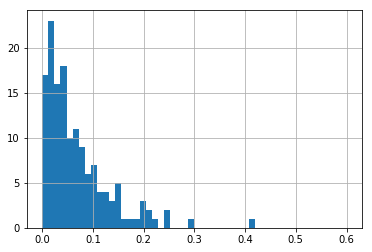

In [27]:
df_compare_banrate["clash"].hist(bins=50, range=(0, 0.6))

In [28]:
pick_ban_data = []

for g in table.find({"platformId":"EUW1","queueId":440},{"gameId":1,"teams":1,"participants":1}):
    team_bans = get_team_bans(g)
    team_picks = get_team_picks(g)
    
    for teamId in [100,200]:
        win = g["teams"][0 if teamId == 100 else 1]["win"] == "Win"
        
        type_ = "ban"
        for ban in team_bans[teamId]:
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":ban,
                "champion":dd.getChampion(ban).name if ban > 0 else "no ban"
            }
            pick_ban_data.append(row)
        
        type_ = "pick"
        for n_role , pick in enumerate(team_picks[teamId]):
            
            row = {
                "gameId":g["gameId"],
                "teamId":teamId,
                "win":win,
                "type":type_,
                "championId":pick,
                "champion":dd.getChampion(pick).name
            }
            pick_ban_data.append(row)

In [29]:
nb_games = table.find({"platformId":"EUW1","queueId":440},{"gameId":1,"teams":1,"participants":1}).count()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


In [30]:
df = pd.DataFrame(pick_ban_data)
df

,gameId,teamId,win,type,championId,champion
0,4208070956,100,True,ban,8,Vladimir
1,4208070956,100,True,ban,555,Pyke
2,4208070956,100,True,ban,121,Kha'Zix
3,4208070956,100,True,ban,24,Jax
4,4208070956,100,True,ban,127,Lissandra
...,...,...,...,...,...,...
4953507,3166191696,200,True,pick,223,Tahm Kench
4953508,3166191696,200,True,pick,83,Yorick
4953509,3166191696,200,True,pick,68,Rumble
4953510,3166191696,200,True,pick,33,Rammus


In [31]:
banrate = (
    # Selecting bans
    df[df["type"] == "ban"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most banned champions
        .sort_values("championId", ascending=False)
        ["championId"]
        # Divided by number of games to get a percentage
        /nb_games
)

banrate.head(10)

champion
Yasuo         0.553404
Pyke          0.539664
Morgana       0.529813
Zed           0.520357
Blitzcrank    0.414232
Darius        0.413211
Draven        0.313279
Master Yi     0.279235
Jax           0.263037
Akali         0.262621
Name: championId, dtype: float64

In [32]:
pickrate = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
        # Divided by number of games to get a percentage
        /nb_games
)

pickrate.head(10)

champion
Caitlyn       0.217470
Yasuo         0.213917
Thresh        0.199487
Kai'Sa        0.198300
Lux           0.186854
Lee Sin       0.180257
Blitzcrank    0.176845
Ezreal        0.172012
Jhin          0.171080
Ashe          0.169570
Name: championId, dtype: float64

In [33]:
wins = (
    # Selecting picks
    df[((df["type"] == "pick") & (df["win"]))]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

picks = (
    # Selecting picks
    df[df["type"] == "pick"]
        # We want champions
        .groupby("champion")
        .count()
        # Sorted by most picked champions
        .sort_values("championId", ascending=False)
        ["championId"]
)

winrate = (wins/picks).fillna(0).sort_values(ascending=False)
winrate.head(10)

champion
Yorick      0.540934
Zac         0.536888
Volibear    0.535655
Vi          0.533701
Urgot       0.532035
Kayle       0.531258
Nami        0.530541
Malzahar    0.529808
Ashe        0.529465
Jinx        0.527966
Name: championId, dtype: float64

In [34]:
presence = pickrate.add(banrate, fill_value=0).sort_values(ascending=False)
presence

champion
Yasuo           0.767321
Pyke            0.691489
Morgana         0.679716
Zed             0.628161
Blitzcrank      0.591077
                  ...   
Taric           0.018673
Kog'Maw         0.018467
Aurelion Sol    0.018060
Skarner         0.015948
Taliyah         0.014176
Name: championId, Length: 146, dtype: float64

In [35]:
ban_winrate = {}
gby = df.groupby("champion")
for i in df["champion"].unique():
    val_count = gby.get_group(i)["win"].value_counts()
    ban_winrate[i] = val_count[True] / (val_count[True] + val_count[False])

In [36]:
df_flex = pd.DataFrame([banrate,pickrate,winrate, presence, pd.Series(ban_winrate)]).T.fillna(0)
df_flex.columns = ["banrate", "pickrate", "winrate", "presence", "ban_winrate"]

df_flex

,banrate,pickrate,winrate,presence,ban_winrate
Yasuo,0.553404,0.213917,0.503897,0.767321,0.498290
Pyke,0.539664,0.151825,0.508457,0.691489,0.502902
Morgana,0.529813,0.149903,0.505064,0.679716,0.508785
Zed,0.520357,0.107804,0.489158,0.628161,0.496134
Blitzcrank,0.414232,0.176845,0.523321,0.591077,0.507883
...,...,...,...,...,...
Trundle,0.001995,0.020212,0.501598,0.022206,0.499818
Taric,0.001926,0.016747,0.518804,0.018673,0.513946
Maokai,0.001768,0.017523,0.499309,0.019291,0.496651
Viktor,0.001728,0.017260,0.494269,0.018988,0.491814


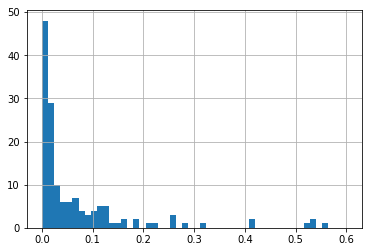

In [37]:
banrate.hist(bins=50, range=(0, 0.6))

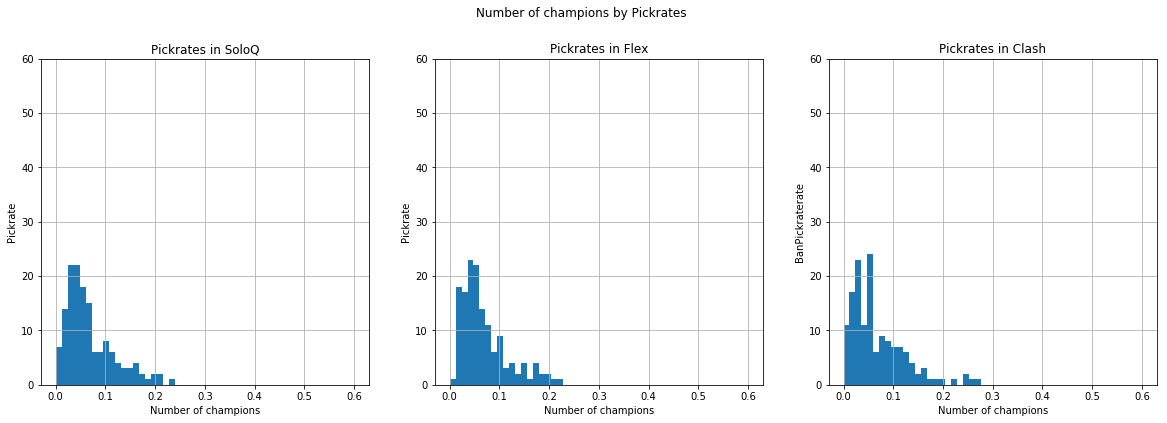

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3)

df_ranked["pickrate"].hist(bins=50, figsize=(6,6), range=(0, 0.6), ax=axes[0])
axes[0].set_ylim([0,60])
axes[0].set_ylabel("Pickrate")
axes[0].set_xlabel("Number of champions")
axes[0].set_title("Pickrates in SoloQ")

pickrate.hist(bins=50, range=(0, 0.6), figsize=(6,6), ax=axes[1])
axes[1].set_ylim([0,60])
axes[1].set_ylabel("Pickrate")
axes[1].set_xlabel("Number of champions")
axes[1].set_title("Pickrates in Flex")

df_clash["pickrate"].hist(bins=50, figsize=(6,6), range=(0, 0.6), ax=axes[2])
axes[2].set_ylim([0,60])
axes[2].set_ylabel("BanPickraterate")
axes[2].set_xlabel("Number of champions")
axes[2].set_title("Pickrates in Clash")

fig.suptitle("Number of champions by Pickrates", y=1)
fig.set_size_inches(20, 6)
fig.show()

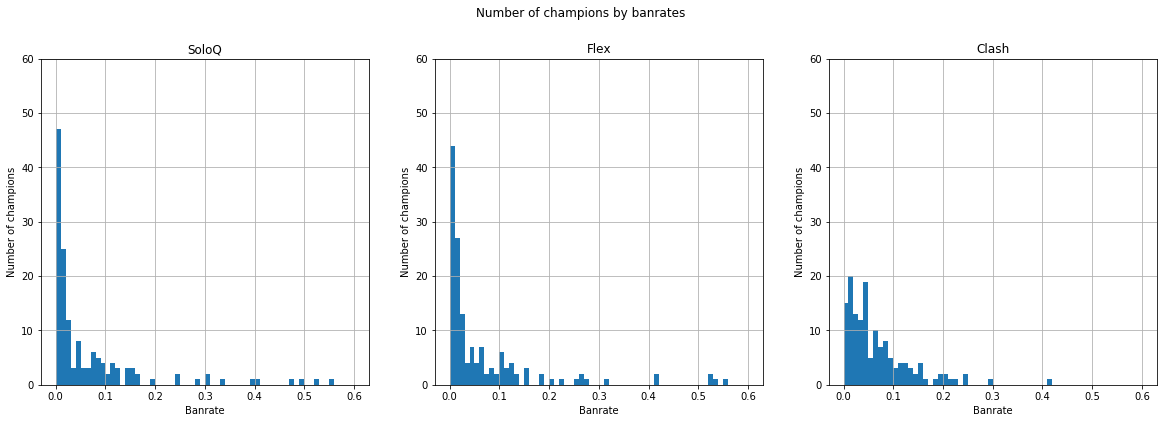

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3)

df_ranked["banrate"].hist(bins=60, figsize=(6,6), range=(0, 0.6), ax=axes[0])
axes[0].set_ylim([0,60])
axes[0].set_xlabel("Banrate")
axes[0].set_ylabel("Number of champions")
axes[0].set_title("SoloQ")

banrate.hist(bins=60, range=(0, 0.6), figsize=(6,6), ax=axes[1])
axes[1].set_ylim([0,60])
axes[1].set_xlabel("Banrate")
axes[1].set_ylabel("Number of champions")
axes[1].set_title("Flex")

df_clash["banrate"].hist(bins=60, figsize=(6,6), range=(0, 0.6), ax=axes[2])
axes[2].set_ylim([0,60])
axes[2].set_xlabel("Banrate")
axes[2].set_ylabel("Number of champions")
axes[2].set_title("Clash")

fig.suptitle("Number of champions by banrates", y=1)
fig.set_size_inches(20, 6)
fig.show()

In [40]:
table_masteries = client.clash.masteries

champion_levels_by_summonerId = {}
for m in table_masteries.find():
    champion_levels_by_summonerId[m["summonerId"]] = m["championLevels"]

In [41]:
nb_bans = 0
nb_bans_against_lvl_7 = 0
nb_team_lvl_7 = []

def get_team_bans_(game_data):
    team_bans = {100:[],200:[]}
    for t in game_data["teams"]:
        for b in t["bans"]:
            if b["championId"] > 0:
                team_bans[t["teamId"]].append(b["championId"])
    return team_bans

def get_team_lvl_7(game_data):
    team_lvl_7 = {100:set(),200:set()}
    
    participantId_to_teamId = {}
    for p in game_data["participants"]:
        participantId_to_teamId[p["participantId"]] = p["teamId"]
    
    for p in game_data["participantIdentities"]:
        for c in champion_levels_by_summonerId[p["player"]["summonerId"]]["7"]:
            team_lvl_7[participantId_to_teamId[p["participantId"]]].add(c)
    
    return team_lvl_7

for g in table.find({"platformId":"EUW1","queueId":700},{"gameId":1,"teams":1,"participants":1,"participantIdentities":1}):
    team_bans = get_team_bans_(g)
    team_lvl_7 = get_team_lvl_7(g)
    
    for teamId in [100,200]:
        nb_team_lvl_7.append(team_lvl_7[teamId])
        other_team = 100 if teamId == 200 else 200
        type_ = "ban"
        for ban in team_bans[teamId]:
            nb_bans += 1
            if ban in team_lvl_7[other_team]:
                nb_bans_against_lvl_7 += 1

In [42]:
print("Part of bans against champions with Mastery 7 on the other team : ", nb_bans_against_lvl_7/nb_bans)

Part of bans against champions with Mastery 7 on the other team :  0.6009333576980925


In [43]:
pd.Series([len(i) for i in nb_team_lvl_7]).mean()

27.13847060058554

In [44]:
otp = {}
for m in table_masteries.find():
    if m["details"][0]["championPoints"] > (sum([i["championPoints"] for i in m["details"]])/2):
        otp[m["summonerId"]] = m["details"][0]["championId"]

In [45]:
len(otp)

2324

In [46]:
otp_playing = 0
opt_playing_champion = 0
opt_playing_champion_winning = 0
opt_banned = 0

for g in table.find({"platformId":"EUW1","queueId":700},{"gameId":1,"teams":1,"participants":1,"participantIdentities":1}):
    team_bans = get_team_bans_(g)
    
    participants_summonerId = {}
    for p in g["participantIdentities"]:
        participants_summonerId[p["participantId"]] = p["player"]["summonerId"]
    
    for p in g["participants"]:
        if participants_summonerId[p["participantId"]] in otp.keys():
            otp_playing += 1
            
            other_team = 100 if p["teamId"] == 200 else 200
            if otp[participants_summonerId[p["participantId"]]] in team_bans[other_team]:
                opt_banned += 1
            
            if otp[participants_summonerId[p["participantId"]]] == p["championId"]:
                opt_playing_champion += 1
                if p["stats"]["win"]:
                    opt_playing_champion_winning += 1

In [47]:
print("OTP having their champion banned", opt_banned/otp_playing)
print("OTP playing their champion", opt_playing_champion/otp_playing)
print("OTP playing", otp_playing)
print("OTP winning with their champion", opt_playing_champion_winning/opt_playing_champion)

OTP having their champion banned 0.6887592788971368
OTP playing their champion 0.19273594909862143
OTP playing 7544
OTP winning with their champion 0.48762035763411277


In [48]:
df_clash.sort_values("pickrate")[-10:]

,banrate,pickrate,winrate,presence,ban_winrate
Jarvan IV,0.097465,0.163123,0.517912,0.260588,0.508169
Leona,0.096567,0.163753,0.511717,0.260320,0.513218
Malphite,0.152053,0.173562,0.511559,0.325616,0.509493
Thresh,0.198570,0.182532,0.511790,0.381102,0.494261
Rakan,0.105922,0.196354,0.508257,0.302276,0.505692
Nautilus,0.112092,0.218154,0.518526,0.330246,0.512556
Caitlyn,0.197998,0.248003,0.509171,0.446001,0.506054
Kai'Sa,0.244562,0.248352,0.478208,0.492914,0.485411
Morgana,0.290262,0.262046,0.510505,0.552308,0.523093
Xayah,0.181272,0.274818,0.511141,0.456090,0.506087


In [49]:
df_ranked.sort_values("pickrate")[-10:]

,banrate,pickrate,winrate,presence,ban_winrate
Ezreal,0.042795,0.160829,0.459059,0.203624,0.467760
Morgana,0.475982,0.163996,0.498236,0.639978,0.505422
Jhin,0.043687,0.178528,0.516474,0.222215,0.510392
Ashe,0.027409,0.178752,0.527470,0.206161,0.522072
Thresh,0.070808,0.186504,0.482922,0.257313,0.485633
Jinx,0.058212,0.192546,0.523912,0.250758,0.516183
Kai'Sa,0.104944,0.203775,0.473684,0.308720,0.480866
Lux,0.060195,0.205252,0.501990,0.265448,0.498277
Yasuo,0.554382,0.205385,0.503363,0.759767,0.500505
Caitlyn,0.169502,0.236826,0.504824,0.406328,0.501186


In [50]:
df_compare_pickrate = pd.DataFrame({"clash":df_clash["pickrate"],"ranked":df_ranked["pickrate"]})

df_compare_pickrate["difference"] = df_compare_pickrate["clash"] - df_compare_pickrate["ranked"]

df_compare_pickrate.sort_values("difference")

,clash,ranked,difference
Yasuo,0.110028,0.205385,-0.095358
Teemo,0.024751,0.100533,-0.075782
Master Yi,0.040358,0.111422,-0.071064
Lux,0.137660,0.205252,-0.067592
Lee Sin,0.087749,0.154168,-0.066419
...,...,...,...
Nautilus,0.218154,0.122965,0.095189
Sejuani,0.118857,0.021934,0.096923
Morgana,0.262046,0.163996,0.098050
Rakan,0.196354,0.093430,0.102924


In [51]:
from tabulate import tabulate

In [52]:
df_compare_pickrate_styled = pd.DataFrame()

In [53]:
df_compare_pickrate_styled["clash"] = df_compare_pickrate['clash'].map('{:,.2%}'.format)
df_compare_pickrate_styled["ranked"] = df_compare_pickrate['ranked'].map('{:,.2%}'.format)
df_compare_pickrate_styled["difference_n"] = df_compare_pickrate['difference']*100
df_compare_pickrate_styled["difference"] = df_compare_pickrate_styled["difference_n"].map('{:,.2}'.format)

In [54]:
df_compare_pickrate_styled

,clash,ranked,difference_n,difference
Aatrox,3.67%,3.31%,0.365839,0.37
Ahri,13.18%,10.25%,2.925950,2.9
Akali,7.66%,9.86%,-2.202345,-2.2
Alistar,4.96%,3.31%,1.646690,1.6
Amumu,9.48%,5.67%,3.812961,3.8
...,...,...,...,...
Ziggs,2.50%,2.51%,-0.005980,-0.006
Zilean,1.96%,3.15%,-1.196163,-1.2
Zoe,3.58%,4.16%,-0.578683,-0.58
Zyra,3.46%,6.13%,-2.669338,-2.7


In [55]:
print(tabulate(df_compare_pickrate_styled.sort_values("difference_n")[["clash","ranked","difference"]], tablefmt="pipe", headers="keys"))

|                | clash   | ranked   |   difference |
|:---------------|:--------|:---------|-------------:|
| Yasuo          | 11.00%  | 20.54%   |       -9.5   |
| Teemo          | 2.48%   | 10.05%   |       -7.6   |
| Master Yi      | 4.04%   | 11.14%   |       -7.1   |
| Lux            | 13.77%  | 20.53%   |       -6.8   |
| Lee Sin        | 8.77%   | 15.42%   |       -6.6   |
| Tryndamere     | 2.59%   | 8.93%    |       -6.3   |
| Riven          | 2.70%   | 8.86%    |       -6.2   |
| Zed            | 5.45%   | 11.52%   |       -6.1   |
| Kha'Zix        | 8.06%   | 13.85%   |       -5.8   |
| Ashe           | 12.37%  | 17.88%   |       -5.5   |
| Miss Fortune   | 5.71%   | 10.61%   |       -4.9   |
| Katarina       | 3.20%   | 7.99%    |       -4.8   |
| Blitzcrank     | 11.16%  | 15.94%   |       -4.8   |
| Jhin           | 13.11%  | 17.85%   |       -4.7   |
| Vayne          | 9.53%   | 14.22%   |       -4.7   |
| Rengar         | 2.41%   | 6.73%    |       -4.3   |
| Brand   

In [56]:
df_compare_banrate_styled = pd.DataFrame()
df_compare_banrate_styled["clash"] = df_compare_banrate['clash'].map('{:,.2%}'.format)
df_compare_banrate_styled["ranked"] = df_compare_banrate['ranked'].map('{:,.2%}'.format)
df_compare_banrate_styled["difference_n"] = df_compare_banrate['difference']*100
df_compare_banrate_styled["difference"] = df_compare_banrate_styled["difference_n"].map('{:,.2}'.format)

In [57]:
print(tabulate(df_compare_banrate_styled.sort_values("difference_n")[["clash","ranked","difference"]], tablefmt="pipe", headers="keys"))

|                | clash   | ranked   |   difference |
|:---------------|:--------|:---------|-------------:|
| Pyke           | 22.19%  | 52.12%   |     -30      |
| Blitzcrank     | 14.58%  | 40.11%   |     -26      |
| Zed            | 24.96%  | 49.94%   |     -25      |
| Evelynn        | 8.14%   | 28.66%   |     -21      |
| Master Yi      | 13.37%  | 33.86%   |     -20      |
| Darius         | 20.18%  | 39.76%   |     -20      |
| Morgana        | 29.03%  | 47.60%   |     -19      |
| Draven         | 15.31%  | 30.06%   |     -15      |
| Yasuo          | 41.02%  | 55.44%   |     -14      |
| Akali          | 13.57%  | 24.90%   |     -11      |
| Jax            | 20.60%  | 30.97%   |     -10      |
| no ban         | 4.24%   | 14.44%   |     -10      |
| Malphite       | 15.21%  | 24.03%   |      -8.8    |
| Teemo          | 4.02%   | 12.84%   |      -8.8    |
| Illaoi         | 6.58%   | 14.90%   |      -8.3    |
| Mordekaiser    | 11.04%  | 19.24%   |      -8.2    |
| Brand   

In [58]:
df_ranked

,banrate,pickrate,winrate,presence,ban_winrate
Yasuo,0.554382,0.205385,0.503363,0.759767,0.500505
Pyke,0.521217,0.143376,0.510393,0.664594,0.502024
Zed,0.499372,0.115170,0.496257,0.614542,0.497675
Morgana,0.475982,0.163996,0.498236,0.639978,0.505422
Blitzcrank,0.401111,0.159435,0.531797,0.560546,0.508067
...,...,...,...,...,...
Skarner,0.001352,0.010161,0.493880,0.011513,0.490711
Maokai,0.001269,0.015329,0.499170,0.016598,0.497332
Viktor,0.001178,0.014289,0.476856,0.015467,0.476974
Taric,0.001116,0.015414,0.508589,0.016529,0.506242


In [85]:
df_ranked_style = pd.DataFrame()
df_ranked_style["Banrate"] = df_ranked['banrate'].map('{:,.2%}'.format)
df_ranked_style["Pickrate"] = df_ranked['pickrate'].map('{:,.2%}'.format)
df_ranked_style["Winrate"] = df_ranked['winrate'].map('{:,.2%}'.format)
df_ranked_style["Presence"] = df_ranked["presence"].map('{:,.2%}'.format)
df_ranked_style["Ban Winrate"] = df_ranked['ban_winrate'].map('{:,.2%}'.format)
df_ranked_style["presence_n"] = df_ranked["presence"]

In [87]:
print(tabulate(df_ranked_style.sort_values("presence_n", ascending=False)[["Banrate","Pickrate","Winrate","Presence","Ban Winrate"]], tablefmt="pipe", headers="keys"))

|                | Banrate   | Pickrate   | Winrate   | Presence   | Ban Winrate   |
|:---------------|:----------|:-----------|:----------|:-----------|:--------------|
| Yasuo          | 55.44%    | 20.54%     | 50.34%    | 75.98%     | 50.05%        |
| Pyke           | 52.12%    | 14.34%     | 51.04%    | 66.46%     | 50.20%        |
| Morgana        | 47.60%    | 16.40%     | 49.82%    | 64.00%     | 50.54%        |
| Zed            | 49.94%    | 11.52%     | 49.63%    | 61.45%     | 49.77%        |
| Blitzcrank     | 40.11%    | 15.94%     | 53.18%    | 56.05%     | 50.81%        |
| Darius         | 39.76%    | 11.04%     | 49.82%    | 50.81%     | 49.70%        |
| Jax            | 30.97%    | 16.01%     | 51.21%    | 46.98%     | 50.60%        |
| Master Yi      | 33.86%    | 11.14%     | 51.25%    | 45.01%     | 50.36%        |
| Caitlyn        | 16.95%    | 23.68%     | 50.48%    | 40.63%     | 50.12%        |
| Malphite       | 24.03%    | 15.14%     | 50.75%    | 39.17%   

In [90]:
df_clash_style = pd.DataFrame()
df_clash_style["Banrate"] = df_clash['banrate'].map('{:,.2%}'.format)
df_clash_style["Pickrate"] = df_clash['pickrate'].map('{:,.2%}'.format)
df_clash_style["Winrate"] = df_clash['winrate'].map('{:,.2%}'.format)
df_clash_style["Presence"] = df_clash["presence"].map('{:,.2%}'.format)
df_clash_style["Ban Winrate"] = df_clash['ban_winrate'].map('{:,.2%}'.format)
df_clash_style["presence_n"] = df_clash["presence"]

In [91]:
print(tabulate(df_clash_style.sort_values("presence_n", ascending=False)[["Banrate","Pickrate","Winrate","Presence","Ban Winrate"]], tablefmt="pipe", headers="keys"))

|                | Banrate   | Pickrate   | Winrate   | Presence   | Ban Winrate   |
|:---------------|:----------|:-----------|:----------|:-----------|:--------------|
| Morgana        | 29.03%    | 26.20%     | 51.05%    | 55.23%     | 52.31%        |
| Yasuo          | 41.02%    | 11.00%     | 50.69%    | 52.02%     | 48.63%        |
| Kai'Sa         | 24.46%    | 24.84%     | 47.82%    | 49.29%     | 48.54%        |
| Xayah          | 18.13%    | 27.48%     | 51.11%    | 45.61%     | 50.61%        |
| Caitlyn        | 19.80%    | 24.80%     | 50.92%    | 44.60%     | 50.61%        |
| Thresh         | 19.86%    | 18.25%     | 51.18%    | 38.11%     | 49.43%        |
| Jax            | 20.60%    | 13.92%     | 48.72%    | 34.52%     | 49.57%        |
| Pyke           | 22.19%    | 10.86%     | 50.31%    | 33.05%     | 49.25%        |
| Nautilus       | 11.21%    | 21.82%     | 51.85%    | 33.02%     | 51.26%        |
| Jinx           | 16.95%    | 15.75%     | 52.07%    | 32.70%   

In [63]:
df_compare_banrate

,clash,ranked,difference,difference_normalized
Aatrox,0.042247,0.072239,-0.029991,-0.709896
Ahri,0.128620,0.067635,0.060985,0.474149
Akali,0.135747,0.248987,-0.113240,-0.834196
Alistar,0.017543,0.008591,0.008952,0.510284
Amumu,0.048301,0.014637,0.033664,0.696961
...,...,...,...,...
Ziggs,0.008701,0.002058,0.006644,0.763513
Zilean,0.024285,0.007148,0.017137,0.705677
Zoe,0.051952,0.036170,0.015782,0.303776
Zyra,0.037710,0.040483,-0.002773,-0.073524


In [64]:
df_compare_winrate = pd.DataFrame({"clash":df_clash["winrate"],"ranked":df_ranked["winrate"]})

df_compare_winrate["difference"] = df_compare_winrate["clash"] - df_compare_winrate["ranked"]

df_compare_winrate.sort_values("difference")

,clash,ranked,difference
Sona,0.447208,0.507176,-0.059968
Quinn,0.458839,0.509466,-0.050627
Master Yi,0.466763,0.512519,-0.045756
Talon,0.447638,0.489279,-0.041641
Kog'Maw,0.461451,0.500263,-0.038812
...,...,...,...
Gangplank,0.506263,0.475995,0.030268
Azir,0.468611,0.435088,0.033523
Nidalee,0.500671,0.465119,0.035552
Zilean,0.546213,0.510073,0.036141


In [65]:
df_compare_winrate.sort_values("difference").loc["Wukong"]

clash         0.480360
ranked        0.506956
difference   -0.026596
Name: Wukong, dtype: float64

In [66]:
df_compare_winrate_styled = pd.DataFrame()
df_compare_winrate_styled["clash"] = df_compare_winrate['clash'].map('{:,.2%}'.format)
df_compare_winrate_styled["ranked"] = df_compare_winrate['ranked'].map('{:,.2%}'.format)
df_compare_winrate_styled["difference_n"] = df_compare_winrate['difference']*100
df_compare_winrate_styled["difference"] = df_compare_winrate_styled["difference_n"].map('{:,.2}'.format)

In [67]:
print(tabulate(df_compare_winrate_styled.sort_values("difference_n")[["clash","ranked","difference"]], tablefmt="pipe", headers="keys"))

|                | clash   | ranked   |   difference |
|:---------------|:--------|:---------|-------------:|
| Sona           | 44.72%  | 50.72%   |     -6       |
| Quinn          | 45.88%  | 50.95%   |     -5.1     |
| Master Yi      | 46.68%  | 51.25%   |     -4.6     |
| Talon          | 44.76%  | 48.93%   |     -4.2     |
| Kog'Maw        | 46.15%  | 50.03%   |     -3.9     |
| Lulu           | 45.56%  | 49.40%   |     -3.8     |
| Teemo          | 48.49%  | 52.15%   |     -3.7     |
| Janna          | 48.71%  | 52.08%   |     -3.4     |
| Warwick        | 46.86%  | 50.07%   |     -3.2     |
| Fizz           | 49.33%  | 52.26%   |     -2.9     |
| Xin Zhao       | 47.39%  | 50.25%   |     -2.9     |
| Karma          | 44.17%  | 47.00%   |     -2.8     |
| Annie          | 46.30%  | 49.06%   |     -2.8     |
| Diana          | 49.08%  | 51.80%   |     -2.7     |
| Wukong         | 48.04%  | 50.70%   |     -2.7     |
| Soraka         | 49.38%  | 51.97%   |     -2.6     |
| Jax     

In [68]:
import json
with open("/var/ddragon/9.21.1/data/en_US/champion.json","r") as f:
    data_champion = json.load(f)

In [69]:
list_marksman = [data_champion["data"][i]["name"] for i in data_champion["data"] if "Marksman" in data_champion["data"][i]["tags"]]
list_marksman

['Ashe',
 'Azir',
 'Caitlyn',
 'Corki',
 'Draven',
 'Ezreal',
 'Graves',
 'Jayce',
 'Jhin',
 'Jinx',
 "Kai'Sa",
 'Kalista',
 'Kennen',
 'Kindred',
 "Kog'Maw",
 'Lucian',
 'Miss Fortune',
 'Quinn',
 'Sivir',
 'Teemo',
 'Tristana',
 'Twitch',
 'Varus',
 'Vayne',
 'Xayah']

In [70]:
df_compare_winrate_styled.loc[list_marksman]

,clash,ranked,difference_n,difference
Ashe,53.37%,52.75%,0.623429,0.62
Azir,46.86%,43.51%,3.352332,3.4
Caitlyn,50.92%,50.48%,0.434740,0.43
Corki,46.60%,45.81%,0.785837,0.79
Draven,49.56%,50.25%,-0.684085,-0.68
Ezreal,46.79%,45.91%,0.883287,0.88
Graves,53.16%,50.36%,2.802448,2.8
Jayce,46.17%,45.39%,0.776986,0.78
Jhin,51.05%,51.65%,-0.602317,-0.6
Jinx,52.07%,52.39%,-0.324798,-0.32


In [71]:
df_compare_winrate_styled.loc[list_marksman]["difference_n"].describe()

count    25.000000
mean      0.075301
std       2.133662
min      -5.062691
25%      -0.684085
50%       0.452381
75%       1.183881
max       3.352332
Name: difference_n, dtype: float64

In [72]:
list_assassin = [data_champion["data"][i]["name"] for i in data_champion["data"] if "Assassin" in data_champion["data"][i]["tags"]]
list_assassin

['Ahri',
 'Akali',
 'Ekko',
 'Evelynn',
 'Fiora',
 'Fizz',
 'Irelia',
 'Jax',
 'Kassadin',
 'Katarina',
 'Kayn',
 "Kha'Zix",
 'LeBlanc',
 'Lee Sin',
 'Malzahar',
 'Master Yi',
 'Nidalee',
 'Nocturne',
 'Pantheon',
 'Pyke',
 'Qiyana',
 'Quinn',
 'Rengar',
 'Riven',
 'Shaco',
 'Sylas',
 'Talon',
 'Teemo',
 'Tristana',
 'Tryndamere',
 'Twitch',
 'Vayne',
 'Vi',
 'Xin Zhao',
 'Yasuo',
 'Zed']

In [73]:
df_compare_winrate_styled.loc[list_assassin]["difference_n"].describe()

count    36.000000
mean     -0.536095
std       2.106573
min      -5.062691
25%      -1.975178
50%      -0.442700
75%       0.965447
max       3.555171
Name: difference_n, dtype: float64

In [74]:
df_compare_winrate_styled.loc[list_assassin]

,clash,ranked,difference_n,difference
Ahri,51.41%,51.83%,-0.418407,-0.42
Akali,45.66%,44.70%,0.962872,0.96
Ekko,53.13%,51.59%,1.532731,1.5
Evelynn,48.45%,49.57%,-1.122142,-1.1
Fiora,50.48%,50.52%,-0.045320,-0.045
Fizz,49.33%,52.26%,-2.931293,-2.9
Irelia,46.98%,45.31%,1.666527,1.7
Jax,48.72%,51.21%,-2.491975,-2.5
Kassadin,51.66%,51.41%,0.254181,0.25
Katarina,47.59%,49.99%,-2.395813,-2.4


In [100]:
df_clash.loc[list_marksman].sort_values("ban_winrate")

,banrate,pickrate,winrate,presence,ban_winrate
Kalista,0.004397,0.007138,0.437908,0.011536,0.469161
Varus,0.009798,0.028904,0.473769,0.038702,0.475286
Corki,0.012656,0.025358,0.465961,0.038013,0.475299
Jayce,0.009646,0.009903,0.461720,0.019549,0.476134
Ezreal,0.082302,0.140949,0.467891,0.223251,0.476176
Azir,0.019048,0.018394,0.468611,0.037442,0.480062
Lucian,0.090199,0.118939,0.478474,0.209138,0.480535
Vayne,0.213302,0.095343,0.506729,0.308644,0.483051
Kai'Sa,0.244562,0.248352,0.478208,0.492914,0.485411
Draven,0.153115,0.047916,0.495618,0.201031,0.486626


In [94]:
df_clash.loc[list_assassin].sort_values("ban_winrate")

,banrate,pickrate,winrate,presence,ban_winrate
Sylas,0.086186,0.052045,0.430076,0.138231,0.463083
Irelia,0.087912,0.053282,0.469790,0.141194,0.470715
LeBlanc,0.069332,0.040160,0.462968,0.109491,0.472355
Lee Sin,0.152905,0.087749,0.471620,0.240654,0.472761
Akali,0.135747,0.076587,0.456595,0.212334,0.475225
Vayne,0.213302,0.095343,0.506729,0.308644,0.483051
Riven,0.118694,0.027037,0.481881,0.145732,0.483432
Yasuo,0.410169,0.110028,0.506944,0.520196,0.486322
Quinn,0.009716,0.008643,0.458839,0.018359,0.486658
Xin Zhao,0.022453,0.035716,0.473873,0.058169,0.486866


In [96]:
list_support = [data_champion["data"][i]["name"] for i in data_champion["data"] if "Support" in data_champion["data"][i]["tags"]]
list_support

['Alistar',
 'Anivia',
 'Ashe',
 'Bard',
 'Braum',
 'Fiddlesticks',
 'Heimerdinger',
 'Ivern',
 'Janna',
 'Karma',
 'Kayle',
 'Leona',
 'Lulu',
 'Lux',
 'Morgana',
 'Nami',
 'Neeko',
 'Orianna',
 'Pyke',
 'Rakan',
 'Sona',
 'Soraka',
 'Syndra',
 'Tahm Kench',
 'Taliyah',
 'Taric',
 'Thresh',
 'Yuumi',
 'Zilean',
 'Zoe',
 'Zyra']

In [97]:
df_clash.loc[list_support].sort_values("ban_winrate")

,banrate,pickrate,winrate,presence,ban_winrate
Karma,0.019922,0.053923,0.441705,0.073846,0.455062
Tahm Kench,0.010381,0.013110,0.439502,0.023492,0.471202
Yuumi,0.088449,0.057446,0.425787,0.145895,0.485050
Lulu,0.056874,0.082337,0.455589,0.139211,0.487222
Braum,0.030595,0.092858,0.482728,0.123453,0.490268
Neeko,0.045210,0.076890,0.481644,0.122100,0.492167
Pyke,0.221945,0.108593,0.503115,0.330538,0.492519
Alistar,0.017543,0.049561,0.490233,0.067104,0.492786
Thresh,0.198570,0.182532,0.511790,0.381102,0.494261
Taliyah,0.009436,0.010906,0.502674,0.020342,0.498280


In [98]:
list_tank = [data_champion["data"][i]["name"] for i in data_champion["data"] if "Tank" in data_champion["data"][i]["tags"]]
list_tank

['Aatrox',
 'Alistar',
 'Amumu',
 'Blitzcrank',
 'Braum',
 'Camille',
 "Cho'Gath",
 'Darius',
 'Dr. Mundo',
 'Galio',
 'Garen',
 'Gnar',
 'Hecarim',
 'Illaoi',
 'Jarvan IV',
 'Kled',
 'Leona',
 'Malphite',
 'Maokai',
 'Wukong',
 'Nasus',
 'Nautilus',
 'Nunu & Willump',
 'Olaf',
 'Ornn',
 'Poppy',
 'Rammus',
 'Renekton',
 'Sejuani',
 'Shen',
 'Shyvana',
 'Singed',
 'Sion',
 'Skarner',
 'Tahm Kench',
 'Trundle',
 'Udyr',
 'Urgot',
 'Volibear',
 'Warwick',
 'Yorick',
 'Zac']

In [99]:
df_clash.loc[list_tank].sort_values("ban_winrate")

,banrate,pickrate,winrate,presence,ban_winrate
Tahm Kench,0.010381,0.013110,0.439502,0.023492,0.471202
Aatrox,0.042247,0.036742,0.461905,0.078989,0.472682
Sejuani,0.073006,0.118857,0.457507,0.191863,0.473646
Maokai,0.006147,0.034654,0.478963,0.040801,0.479989
Poppy,0.026023,0.063989,0.475027,0.090012,0.487366
Renekton,0.097909,0.098142,0.486213,0.196051,0.489707
Trundle,0.007780,0.026583,0.484423,0.034362,0.489817
Braum,0.030595,0.092858,0.482728,0.123453,0.490268
Warwick,0.032776,0.054040,0.468595,0.086816,0.491200
Alistar,0.017543,0.049561,0.490233,0.067104,0.492786


In [101]:
list_mage = [data_champion["data"][i]["name"] for i in data_champion["data"] if "Mage" in data_champion["data"][i]["tags"]]
print(list_mage)
df_clash.loc[list_mage].sort_values("ban_winrate")

['Ahri', 'Amumu', 'Anivia', 'Annie', 'Aurelion Sol', 'Azir', 'Bard', 'Brand', 'Cassiopeia', "Cho'Gath", 'Diana', 'Elise', 'Evelynn', 'Ezreal', 'Fiddlesticks', 'Galio', 'Gragas', 'Heimerdinger', 'Ivern', 'Janna', 'Jhin', 'Karma', 'Karthus', 'Kassadin', 'Katarina', 'Kennen', "Kog'Maw", 'LeBlanc', 'Lissandra', 'Lulu', 'Lux', 'Malzahar', 'Maokai', 'Morgana', 'Nami', 'Neeko', 'Nidalee', 'Orianna', 'Rumble', 'Ryze', 'Sona', 'Soraka', 'Swain', 'Sylas', 'Syndra', 'Taliyah', 'Twisted Fate', 'Varus', 'Veigar', "Vel'Koz", 'Viktor', 'Vladimir', 'Xerath', 'Yuumi', 'Ziggs', 'Zilean', 'Zoe', 'Zyra']


,banrate,pickrate,winrate,presence,ban_winrate
Karma,0.019922,0.053923,0.441705,0.073846,0.455062
Gragas,0.030700,0.058274,0.459167,0.088974,0.460147
Sylas,0.086186,0.052045,0.430076,0.138231,0.463083
LeBlanc,0.069332,0.040160,0.462968,0.109491,0.472355
Ryze,0.029090,0.048884,0.466714,0.077975,0.474645
Varus,0.009798,0.028904,0.473769,0.038702,0.475286
Ezreal,0.082302,0.140949,0.467891,0.223251,0.476176
Viktor,0.011932,0.018523,0.473552,0.030455,0.477212
Maokai,0.006147,0.034654,0.478963,0.040801,0.479989
Azir,0.019048,0.018394,0.468611,0.037442,0.480062


In [103]:
list_fighter = [data_champion["data"][i]["name"] for i in data_champion["data"] if "Fighter" in data_champion["data"][i]["tags"]]
print(list_fighter)
df_clash.loc[list_fighter].sort_values("ban_winrate")[:30]

['Aatrox', 'Blitzcrank', 'Camille', 'Darius', 'Diana', 'Dr. Mundo', 'Ekko', 'Elise', 'Fiora', 'Fizz', 'Gangplank', 'Garen', 'Gnar', 'Gragas', 'Hecarim', 'Illaoi', 'Irelia', 'Jarvan IV', 'Jax', 'Jayce', 'Kayle', 'Kayn', 'Kled', 'Lee Sin', 'Malphite', 'Master Yi', 'Wukong', 'Mordekaiser', 'Nasus', 'Nautilus', 'Nocturne', 'Nunu & Willump', 'Olaf', 'Ornn', 'Pantheon', 'Poppy', 'Qiyana', 'Rammus', "Rek'Sai", 'Renekton', 'Rengar', 'Riven', 'Rumble', 'Ryze', 'Sejuani', 'Shyvana', 'Singed', 'Sion', 'Skarner', 'Swain', 'Taric', 'Thresh', 'Trundle', 'Tryndamere', 'Udyr', 'Urgot', 'Vi', 'Volibear', 'Warwick', 'Xin Zhao', 'Yasuo', 'Yorick', 'Zac']


,banrate,pickrate,winrate,presence,ban_winrate
Gragas,0.030700,0.058274,0.459167,0.088974,0.460147
Irelia,0.087912,0.053282,0.469790,0.141194,0.470715
Aatrox,0.042247,0.036742,0.461905,0.078989,0.472682
Lee Sin,0.152905,0.087749,0.471620,0.240654,0.472761
Sejuani,0.073006,0.118857,0.457507,0.191863,0.473646
Ryze,0.029090,0.048884,0.466714,0.077975,0.474645
Jayce,0.009646,0.009903,0.461720,0.019549,0.476134
Rek'Sai,0.020797,0.029464,0.471496,0.050261,0.481782
Riven,0.118694,0.027037,0.481881,0.145732,0.483432
Yasuo,0.410169,0.110028,0.506944,0.520196,0.486322


In [104]:
df_clash.loc[list_fighter].sort_values("ban_winrate")[30:]

,banrate,pickrate,winrate,presence,ban_winrate
Kayn,0.147504,0.126392,0.498154,0.273897,0.499446
Gnar,0.048021,0.093360,0.496502,0.141381,0.500124
Gangplank,0.043414,0.033523,0.506263,0.076937,0.500303
Olaf,0.031785,0.063266,0.507375,0.095051,0.500430
Nasus,0.077146,0.058484,0.508975,0.135630,0.501376
Ornn,0.021532,0.084565,0.509793,0.106097,0.506596
Shyvana,0.016481,0.019339,0.488540,0.035821,0.507327
Nocturne,0.037722,0.055486,0.510616,0.093208,0.507821
Vi,0.064013,0.097804,0.505426,0.161816,0.507893
Jarvan IV,0.097465,0.163123,0.517912,0.260588,0.508169
